<a href="https://colab.research.google.com/github/anushka7220/Abstract_Decoder/blob/main/abstarct_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Purpose of this model is to build an NLP model to make reading medical abstracts easier.

the paper we are replicating is avaialble here

In [ ]:
#confirm access to gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bdc7fd03-49fa-6f95-7e48-c81245f80945)


In [ ]:
#get data , lets download the dataset from the authors github
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 20.04 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Now we are checking what files are in the Punmed_20K dataset

In [ ]:
#check the files are in pubmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


start our experiment using 20K dataset with nnumbers replaced by some sort of sign

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

check all of the filenames in the taregt directory

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### preprocess data

now we have got some text data, its time to become one with it

now lets visualise the data

In [ ]:
 #lets create a function to read the lines of a document
 def get_lines(filename):
  """
  reads filename ( a text filename) and return the lines of text as a list
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
#lets read in the training lines
train_lines = get_lines(data_dir + 'train.txt') #read the lines with training files
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

### lets think about how we want our data to look like

lets write a function wich turns each of our datasets into the above format so we can continue to prepare our data for modelling

what we are basically doing is , we are making sure that the text between ### and /n is get appended.....

In [ ]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    Takes in a file name, reads its contents and sorts through each line,
    giving each line, extracting things like the target label, the text of the sentences,
    how many sentences are in the current abstract, and what sentence number the target line is.
    """
    input_lines = get_lines(filename)  # Get all lines from filename
    abstract_lines = ""  # Create an empty abstract
    abstract_samples = []  # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):  # Check if it is an ID line
            abstract_id = line
            abstract_lines = ""  # Reset the abstract string
        elif line.isspace():  # Check if line is a new line if the line is an ID line
            abstract_line_split = abstract_lines.splitlines()  # Split abstract into lines

            # Extract through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}  # Create an empty dictionary for each line
                target_text_split = abstract_line.split("\t")  # Split target label from text
                if len(target_text_split) == 2:  # Check if split was successful
                    line_data["target"] = target_text_split[0]  # Get target label
                    line_data["text"] = target_text_split[1].lower()  # Get target text and lower it
                    line_data["line_number"] = abstract_line_number
                    line_data["total_lines"] = len(abstract_line_split) - 1  # This shows the number of total lines
                    abstract_samples.append(line_data)  # Append the line data to the abstract samples list

        else:
            abstract_lines += line
    return abstract_samples


now lets get data from file and preprocess it..

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 767 ms, sys: 117 ms, total: 884 ms
Wall time: 1.2 s


### shown our preprocessed data

check the first abstract of our training data

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

lets keep visulising visualising visualising

now that our data is in the format of a list of dicyionaries , how about we turn it into a dataframe to further visualise it...

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


distribution of labels in the training data

In [ ]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


lets check the length of different lines

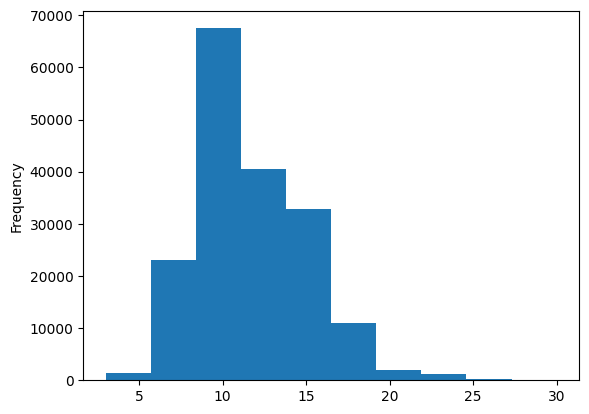

In [ ]:
train_df.total_lines.plot.hist();

### get list of sentances

convert abstract text lines into lines


In [ ]:
#further preprocessing our data
train_sentances = train_df["text"].tolist()
val_sentances = val_df["text"].tolist()
test_sentances = test_df["text"].tolist()
len(train_sentances), len(val_sentances), len(test_sentances)

(180040, 30212, 30135)

now lets veiw the line of first 10 sentances

In [ ]:
train_sentances[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## make numeric labels

In [ ]:
#on hot encoded labels
from sklearn.preprocessing import OneHotEncoder
ones_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = ones_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = ones_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = ones_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

#Check what one hot encoded labels look like
train_labels_one_hot


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### label encode labels

extract labels ('target' columns) and encode them into integers


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#checking the training labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

reverse it now(number to names of labels)

In [ ]:
#get class names and number of classes from label encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## starting a series of modelling experiments

we are starting with baseline (TF IDF multinomial Naive bayes classifier)

### Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
#creating pipeline to turn our texts into numbers which train sentances
from sklearn.pipeline import Pipeline

#create pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#fit the pipeline to the training data
model_0.fit(X=train_sentances,
            y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#evaluate baseline model on validation dataset
model_0.score(X=val_sentances,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
#make predictions using our baseline model
baseline_preds = model_0.predict(val_sentances)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

###download helper function script

In the previous section we wrote a function to compare predictions and rather rewriting it here , download it from our helper function script.....


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-11 16:29:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-11 16:29:59 (32.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
#calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentances[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

`now we vectorize the text, so turning each token into numbers and then create an embedding based upon those tokenised words`

## preparing our data or text for deep sequence model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentances[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
#how long is each sentance on average?
#we will gone through all of the sentances
sent_lens = [len(sentance.split()) for sentance in train_sentances]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

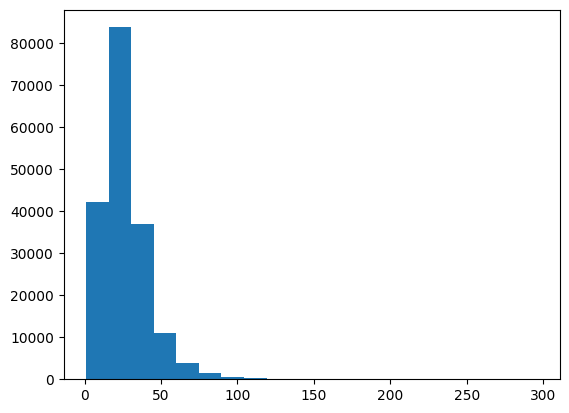

In [ ]:
#whats the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
#HOW LONG OF A SENTANCE LENGTH COVERS 95% OF EXAMPLES
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
#MAXIMUM SEQUENCE LENGTH IN THE TRAINING SET
max(sent_lens)

296

### create text vectorizer layer

we want to make a layer which maps our texts from words to numbers

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55)

In [ ]:
#adapt text vectorizer to training sentances
text_vectorizer.adapt(train_sentances)

In [ ]:
#test out our text vectorizer on random sentanes
import random
target_sentances = random.choice(train_sentances)
print(f"Text:\n {target_sentances}")
print(f"\nlength of text: {len(target_sentances)}")
print(f"\nVectorized text: {text_vectorizer([target_sentances])}")

Text:
 real-time virtual sonography is an innovative imaging technology that detects the spatial position of an ultrasound probe and immediately reconstructs a section of computed tomography ( ct ) and/or magnetic resonance in accordance with the ultrasound image , thereby allowing a real-time comparison of those modalities .

length of text: 320

Vectorized text: [[ 2383  2711  5172    20    26  3748   688  1710    28 16093     2  3432
   1020     4    26   902  4227     3   759 47137     8  2140     4  1490
   1236   663   727  1160  1390     5  4002     7     2   902  1277  3227
   4216     8  2383   421     4   125  2617     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
#how many words in our training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Least common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
#create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,#different embedding have different runtime
                               mask_zero = True,#using masking is more effective way
                               name = "token_embedding")

In [ ]:
#example embedding
print(f"Sentance before vectorization :\n {target_sentances}\n")
vectorized_sentance = text_vectorizer([target_sentances])
print(f"Sentance after vectorization (before embedding) :\n {vectorized_sentance}\n")
embedded_sentance = token_embed(vectorized_sentance)
print(f"Sentance after embedding :\n {embedded_sentance}")
print(f"Embedded sentance shape: {embedded_sentance.shape}")

Sentance before vectorization :
 real-time virtual sonography is an innovative imaging technology that detects the spatial position of an ultrasound probe and immediately reconstructs a section of computed tomography ( ct ) and/or magnetic resonance in accordance with the ultrasound image , thereby allowing a real-time comparison of those modalities .

Sentance after vectorization (before embedding) :
 [[ 2383  2711  5172    20    26  3748   688  1710    28 16093     2  3432
   1020     4    26   902  4227     3   759 47137     8  2140     4  1490
   1236   663   727  1160  1390     5  4002     7     2   902  1277  3227
   4216     8  2383   421     4   125  2617     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentance after embedding :
 [[[ 0.02367753 -0.01203715 -0.03983227 ...  0.01355076 -0.04865636
    0.00035023]
  [-0.00866066  0.01601902 -0.04335009 ... -0.0492295   0.03814304
    0.01686708]
  [ 0.03120377 -0.0307173   0.02228953 ...  0.00348318  0

## creating dataset (making sure data loads as fast as possible)

In [ ]:
#turn our data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentances, train_labels_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentances, val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentances, test_labels_encoded))
train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# train datasettensorflow and turn them into preferred dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
#create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters = 64,
                 kernel_size = 5,
                 activation = "relu", padding="same")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

#compile
# Use sparse_categorical_crossentropy for integer labels
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model_1.summary()

Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5203 - loss: 1.1683 - val_accuracy: 0.7407 - val_loss: 0.6920
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7493 - loss: 0.6818 - val_accuracy: 0.7733 - val_loss: 0.6296
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7740 - loss: 0.6203 - val_accuracy: 0.7909 - val_loss: 0.5903


In [ ]:
#evaluate on whole dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7874 - loss: 0.5962


[0.5973725914955139, 0.787038266658783]

In [ ]:
#make predictions (our model predicts prediction probabilities)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[4.43873167e-01, 1.21894605e-01, 6.79209828e-02, 3.39906812e-01,
         2.64044218e-02],
        [4.21871513e-01, 3.16505641e-01, 1.04128998e-02, 2.42386147e-01,
         8.82382225e-03],
        [1.45867452e-01, 5.45834564e-03, 1.55652233e-03, 8.47101927e-01,
         1.58016719e-05],
        ...,
        [7.60401917e-06, 7.25006219e-04, 6.71301677e-04, 6.35349215e-06,
         9.98589694e-01],
        [3.99751030e-02, 4.38759059e-01, 1.00647323e-01, 4.72182110e-02,
         3.73400331e-01],
        [1.54013216e-01, 7.17302978e-01, 4.01888452e-02, 4.48532142e-02,
         4.36417833e-02]], dtype=float32),
 (30212, 5))

In [ ]:
#convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70382629418773,
 'precision': 0.7842690744069697,
 'recall': 0.7870382629418774,
 'f1': 0.784936002328132}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## MODEL 2: FEATURE EXTRACTION WITH PRETRAINED TOKEN EMBEDDINGS

NOW LETS USE PRETRAINED WORD EMBEDDING FROM TENSORFLOW HUB,MORE SPECIFICALLY UNIVERSAL SENTANCE ENCODER

In [ ]:
#GLOV EEMBEDDING
#TOKEN EMBEDDINGS ARE INITIALISED WITH GLOVE
#NOW LETS DOWNLOAD TENSORFLOW HUB USE
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import random

# Ensure TensorFlow and TensorFlow Hub versions are compatible
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Hub version: {hub.__version__}")

# Load the Universal Sentence Encoder from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")




TensorFlow version: 2.17.0
TensorFlow Hub version: 0.16.1


In [ ]:
# Test out the embedding on a random sentence
random_train_sentance = random.choice(train_sentances)
print(f"Random sentance:\n{random_train_sentance}\n")
use_embedded_sentance = tf_hub_embedding_layer([random_train_sentance])
print(f"Sentance after embedding:\n{use_embedded_sentance[0][:30]} (truncated output)...\n")
print(f"Length of sentance embedding:\n{len(use_embedded_sentance[0])}")


Random sentance:
the strategies and opportunities to stop colorectal cancer ( stop crc ) in priority populations study is a pragmatic trial and a collaboration between two research institutions and a network of more than @ safety net clinics .

Sentance after embedding:
[-0.01699102  0.00074692 -0.029453   -0.04901534  0.01121382 -0.07997753
  0.0479185  -0.02521773  0.0460454   0.01817467  0.07305899 -0.07454681
  0.0764666   0.00121676  0.01865838  0.05525572 -0.081159    0.01573979
  0.0479722  -0.05814247  0.05697223 -0.035127    0.01627878  0.03758967
  0.04233056  0.02252783  0.05797846  0.00096331 -0.04314176  0.03434976] (truncated output)...

Length of sentance embedding:
512


In [ ]:
#Let's put together and compile a model using our tf_hub_embedding_layer
#now lets build feature extractor model using tf hub layer
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string,name="input_layer")
# Wrap the Hub layer in a Lambda layer to handle KerasTensor, specify output shape
pretrained_embedding = layers.Lambda(lambda x: tf_hub_embedding_layer(x), output_shape=(512,))(inputs)

num_classes=5
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                 jit_compile=False)

In [ ]:
#getting a summary
model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
# Assuming 'train_labels' and 'val_labels' are integer labels corresponding to 'train_dataset' and 'valid_dataset' respectively
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=(valid_dataset),
                              validation_steps=int(0.1 * len(valid_dataset)),
                              verbose=1)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5761 - loss: 1.0908 - val_accuracy: 0.6898 - val_loss: 0.7958
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7032 - loss: 0.7707 - val_accuracy: 0.7111 - val_loss: 0.7562
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7134 - loss: 0.7574 - val_accuracy: 0.7174 - val_loss: 0.7295


In [ ]:
#evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7134 - loss: 0.7412


[0.7431241273880005, 0.7132265567779541]

In [ ]:
#make prediction with feature extraction
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


array([[0.41575092, 0.36768305, 0.00230346, 0.20777223, 0.00649036],
       [0.30666044, 0.5387443 , 0.00327192, 0.14809915, 0.00322423],
       [0.21206976, 0.14925294, 0.01773318, 0.5804427 , 0.04050144],
       ...,
       [0.00233702, 0.00706908, 0.06920043, 0.0011369 , 0.92025656],
       [0.00363867, 0.04325924, 0.22274138, 0.00155493, 0.7288057 ],
       [0.14079183, 0.24549484, 0.5398041 , 0.00562048, 0.06828868]],
      dtype=float32)

In [ ]:
#convert the prediction probabilities found with feature extraction
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.3226532503641,
 'precision': 0.7133725780839941,
 'recall': 0.713226532503641,
 'f1': 0.7101358938440938}

# MODEL 3: CONV1d WITH CHARACTER EMBEDDINGS

previously we had token embeddings but we will need to do similar steps for character embeddings

### create a character level tokeniser

In [ ]:
train_sentances[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
#split sentances into characters like "tensorflow" ---> "t,e,n,s,...."
def split_chars(text):
  return " ".join(list(text))

In [ ]:
#test splittng non charcater level sequence to characers
split_chars(random_train_sentance)

't h e   s t r a t e g i e s   a n d   o p p o r t u n i t i e s   t o   s t o p   c o l o r e c t a l   c a n c e r   (   s t o p   c r c   )   i n   p r i o r i t y   p o p u l a t i o n s   s t u d y   i s   a   p r a g m a t i c   t r i a l   a n d   a   c o l l a b o r a t i o n   b e t w e e n   t w o   r e s e a r c h   i n s t i t u t i o n s   a n d   a   n e t w o r k   o f   m o r e   t h a n   @   s a f e t y   n e t   c l i n i c s   .'

In [ ]:
#split sequence level splits into character level splits
train_chars = [split_chars(sentance) for sentance in train_sentances]
val_chars = [split_chars(sentance) for sentance in val_sentances]
test_chars = [split_chars(sentance) for sentance in test_sentances]

In [ ]:
print(train_chars[:5])

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .', 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .', 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n 

In [ ]:
#whats the average character length
char_lens = [len(sentance) for sentance in train_sentances]
avg_char_len = np.mean(char_lens)
avg_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

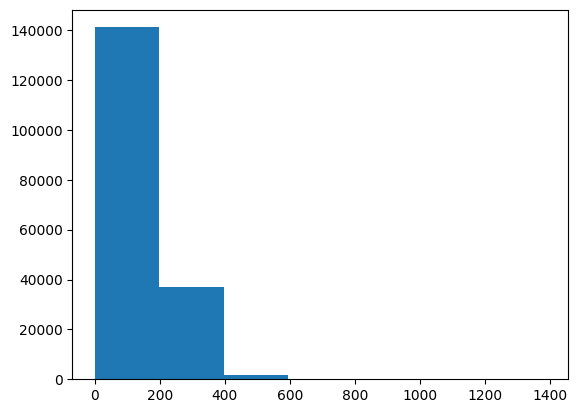

In [ ]:
#checking the distribution of our sequences
import matplotlib.pyplot
plt.hist(char_lens,bins=7)

In [ ]:
#lets find whats character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

now we need to set up text vectorization layer

In [ ]:
#getting all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #adding 2 for space and out of vocab token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    #standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
#adapt character vectorizer to training charcters
char_vectorizer.adapt(train_chars)

In [ ]:
#check characyer vocabs
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of characters in vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
#test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Random sentance:\n{random_train_chars}\n")
print(f"\nLength of random_train_chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_chars}\n")
print(f"Length of vectorized_chars : {len(vectorized_chars[0])}")

Random sentance:
p r o p h y l a c t i c   a n t i b i o t i c s   h a v e   g o t   n o   r o l e   i n   c a s e s   o f   m i l l i g a n   m o r g a n   h e m o r r h o i d e c t o m y   .


Length of random_train_chars : 76
Vectorized chars:
[[14  8  7 14 13 19 12  5 11  3  4 11  5  6  3  4 22  4  7  3  4 11  9 13
   5 21  2 18  7  3  6  7  8  7 12  2  4  6 11  5  9  2  9  7 17 15  4 12
  12  4 18  5  6 15  7  8 18  5  6 13  2 15  7  8  8 13  7  4 10  2 11  3
   7 15 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

### creating a character level embedding layer

In [ ]:
#create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),#numbr of different vocabulary
                              output_dim=25,# this is the size of char embedding layer
                              mask_zero=True,
                              name="char_embed")

In [ ]:
#test our character embedding layer
print(f"charified tect:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Embedded chars shape: {char_embed_example.shape}")

charified tect:
p r o p h y l a c t i c   a n t i b i o t i c s   h a v e   g o t   n o   r o l e   i n   c a s e s   o f   m i l l i g a n   m o r g a n   h e m o r r h o i d e c t o m y   .

Embedded chars (after vectorization and embedding):
[[[-0.02369584 -0.02030232  0.04619202 ... -0.01617464  0.02508631
   -0.03767473]
  [ 0.00370485  0.02224578  0.03481375 ... -0.0427891  -0.04299395
    0.03176678]
  [-0.00382377 -0.04413401  0.04417734 ... -0.00292931  0.00863076
   -0.04357043]
  ...
  [-0.00014336 -0.01899846 -0.00613395 ... -0.01763827 -0.00867605
    0.00174757]
  [-0.00014336 -0.01899846 -0.00613395 ... -0.01763827 -0.00867605
    0.00174757]
  [-0.00014336 -0.01899846 -0.00613395 ... -0.01763827 -0.00867605
    0.00174757]]]

Embedded chars shape: (1, 290, 25)


so here we got above the single sequence and it has 290 characters and turn eah of the characters into 25 long

### building a Conv1D model to fit on character embeddings

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers # Import the layers module

#make conv1D on chars ony
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embeddings")

#compile
model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
summary_string = model_3.summary()
print(summary_string)

Model: "model_3_conv1D_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                          epochs=3,
                          steps_per_epoch=int(0.1*len(train_char_dataset)),
                          validation_data=valid_char_dataset,
                          validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4185 - loss: 1.3857 - val_accuracy: 0.5951 - val_loss: 1.0301
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5819 - loss: 1.0318 - val_accuracy: 0.6253 - val_loss: 0.9505
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6308 - loss: 0.9358 - val_accuracy: 0.6443 - val_loss: 0.8885


In [ ]:
#make predictions with character level only
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[0.22037376, 0.53378314, 0.06102464, 0.15776935, 0.02704907],
       [0.28179628, 0.47259605, 0.01084661, 0.19895744, 0.03580359],
       [0.16557445, 0.19717997, 0.05520921, 0.56292766, 0.01910875],
       ...,
       [0.02033434, 0.0360583 , 0.36876765, 0.01724952, 0.5575901 ],
       [0.01514596, 0.07812887, 0.32605177, 0.02750237, 0.55317104],
       [0.37285355, 0.33648163, 0.11449169, 0.13843319, 0.03773988]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
#calculate results for con1d model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.85793724347941,
 'precision': 0.6562416967061439,
 'recall': 0.6585793724347941,
 'f1': 0.6491196543022162}

## Model 4: combining pretrained token embeddings + character embeddings(hybrid model)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, Bidirectional

# Define the token input model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")  # Sequence of strings
# Wrap the Hub layer in a Lambda layer to handle KerasTensors
token_embeddings = layers.Lambda(lambda x: tf_hub_embedding_layer(tf.squeeze(tf.cast(x, tf.string))))(token_inputs)

token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs, name="token_model")
# Define the char input model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")  # Sequence of strings
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
masking_layer = layers.Masking(mask_value=0)(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences=True))(masking_layer)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Add a GlobalAveragePooling1D layer to the char model to flatten the output
char_pooling = layers.GlobalAveragePooling1D()(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_pooling)

# Concatenate token and char models
token_char_concat = layers.Concatenate(name="token_char_concat")([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct the final model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="model_4_token_and_char_embeddings")


In [ ]:
#get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 290, 25)        │              0 │ char_embed[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 290, 25)        │              0 │ char_embed[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 290)            │              0 │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 290, 48)        │          9,600 │ masking[0][0],         │
│ (Bidirectional)           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,664 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 48)             │              0 │ bidirectional[0][0],   │
│ (GlobalAveragePooling1D)  │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_concat         │ (None, 176)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 176)            │              0 │ token_char_concat[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

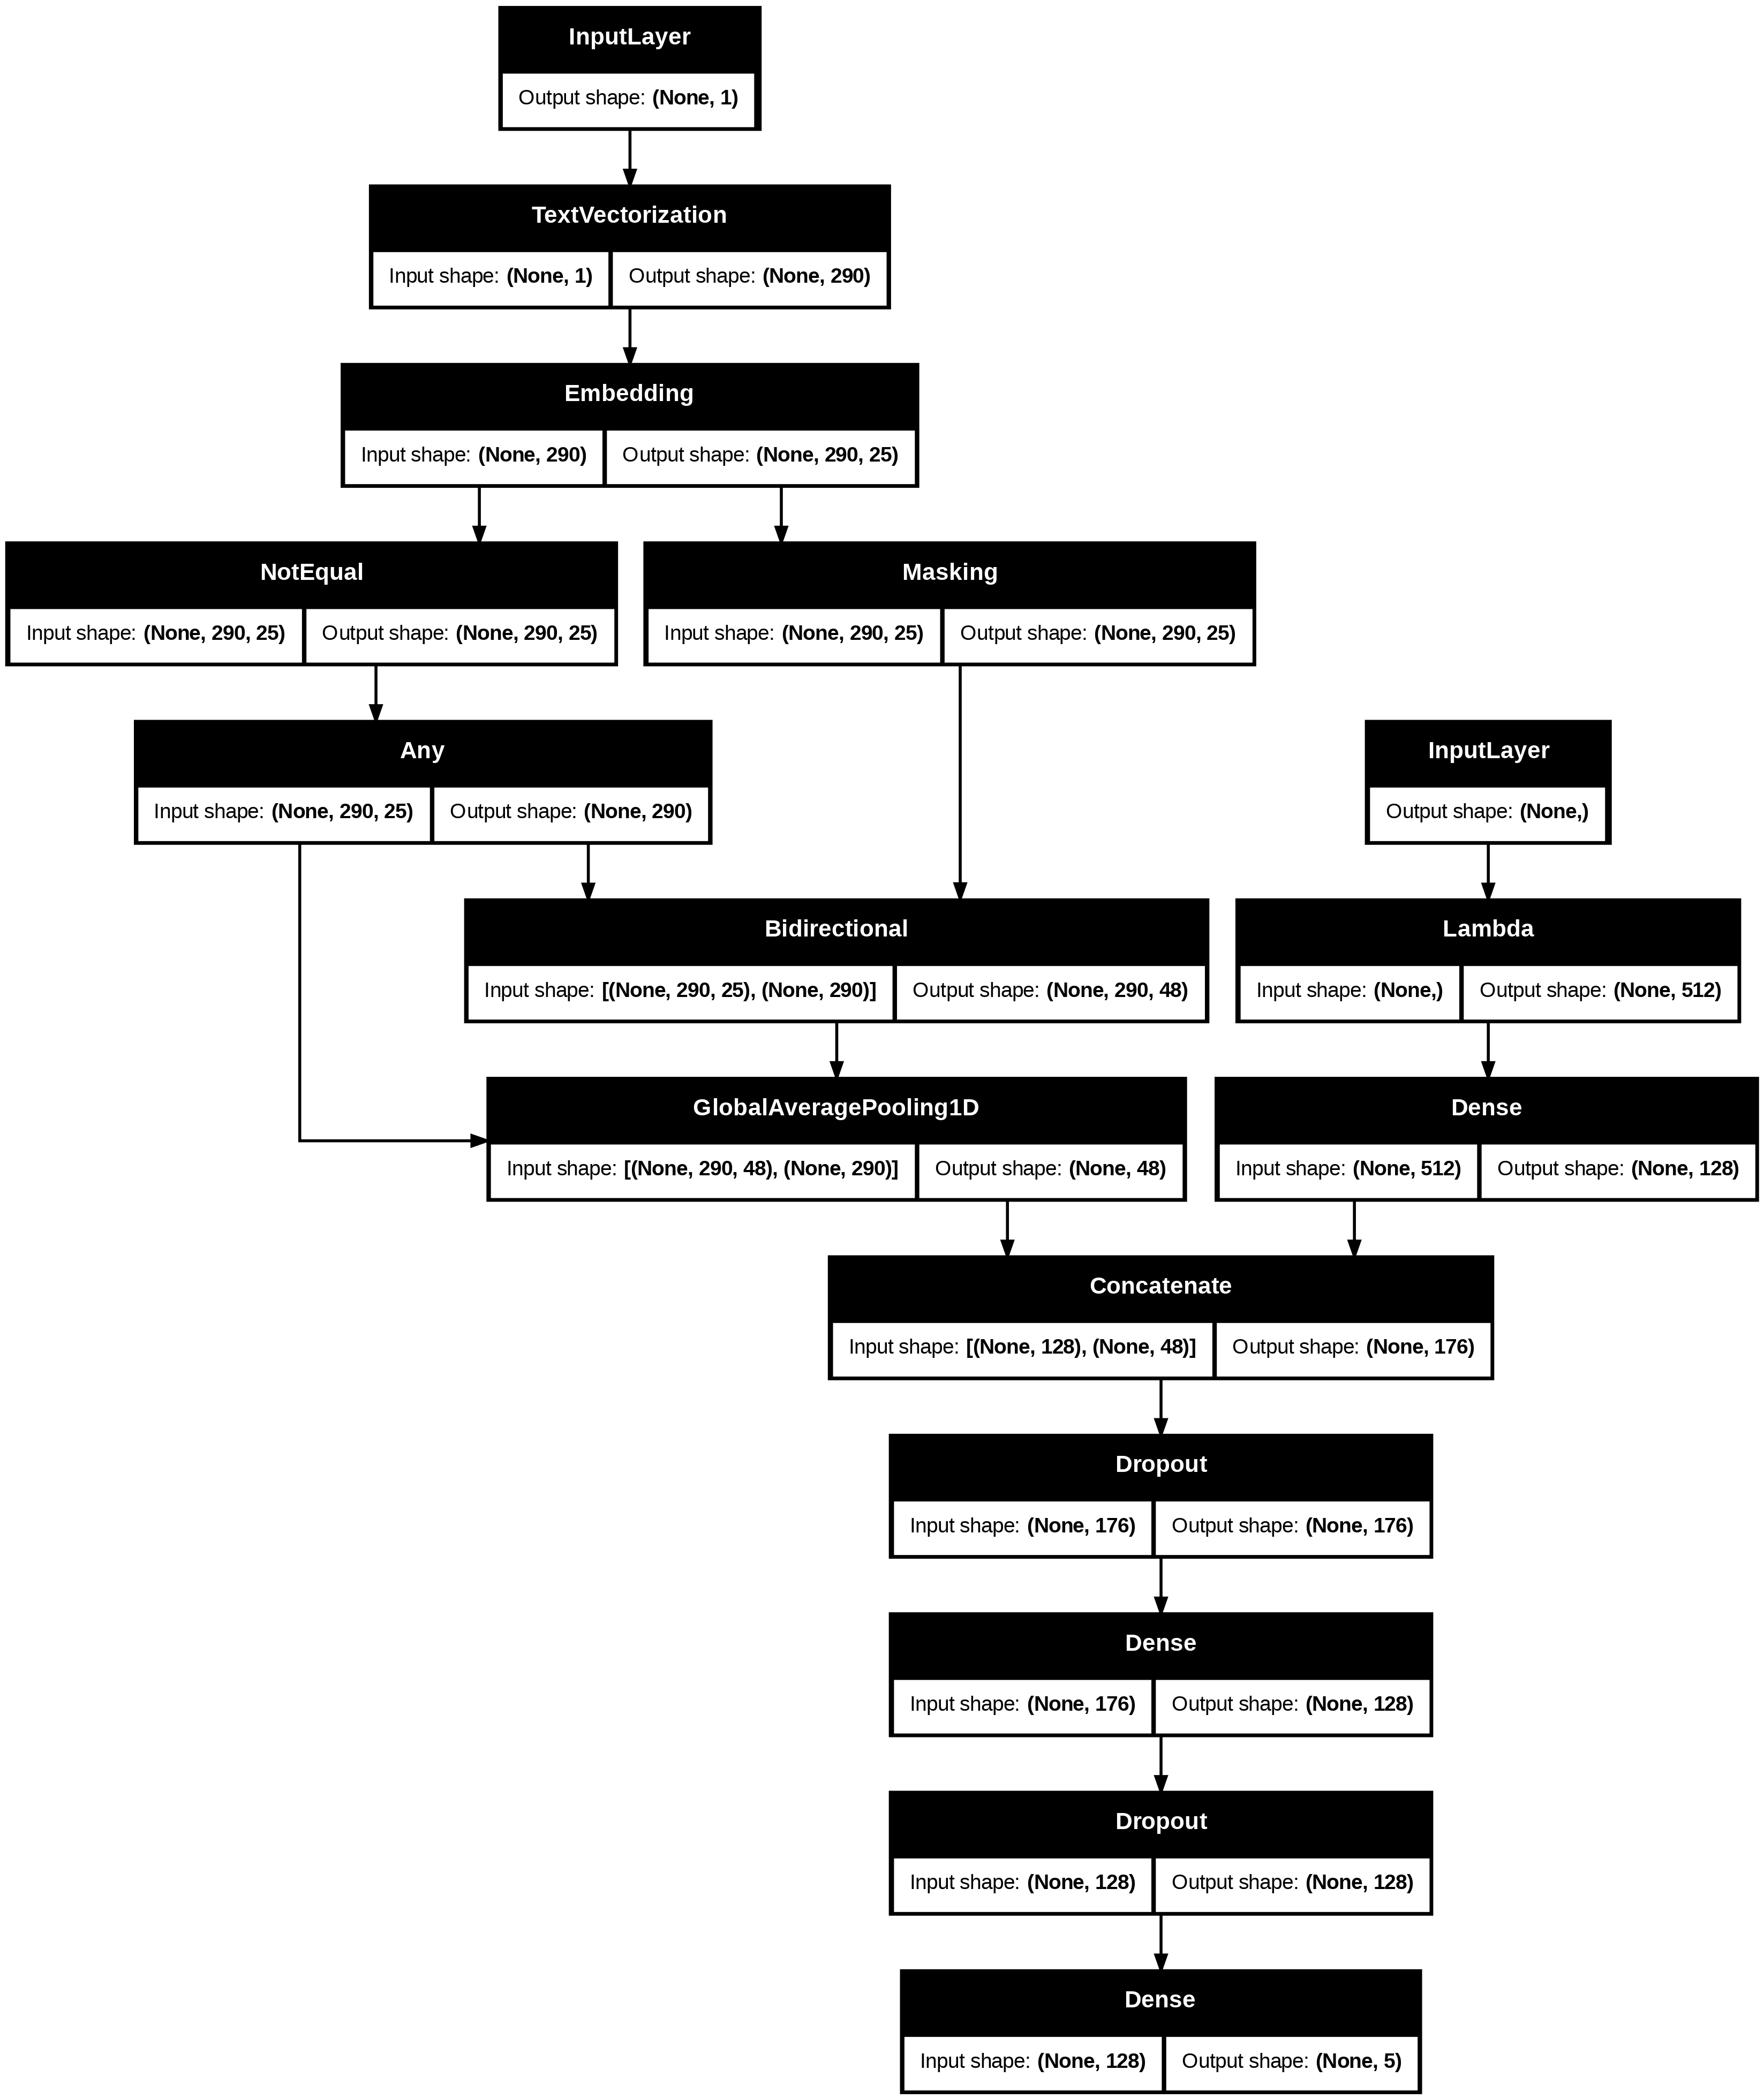

In [ ]:
#plot hybrid token and charcter model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
#compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### combining token and character data into tf.data Dataset

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentances, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentances, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
#checkout our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character level embeddigs

In [ ]:
# Fit the model (no changes needed here)
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.5185 - loss: 1.1614 - val_accuracy: 0.6772 - val_loss: 0.8143
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.6741 - loss: 0.8415 - val_accuracy: 0.7151 - val_loss: 0.7514
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.6925 - loss: 0.8036 - val_accuracy: 0.7181 - val_loss: 0.7208


In [ ]:
#evaluate on whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.7210 - loss: 0.7272


[0.7272689938545227, 0.719813346862793]

In [ ]:
#make predictions using token character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step


array([[4.0947613e-01, 3.6777413e-01, 3.4172034e-03, 2.1223491e-01,
        7.0977015e-03],
       [3.1803349e-01, 5.1842773e-01, 2.5230523e-03, 1.5977269e-01,
        1.2431002e-03],
       [2.4385609e-01, 1.4935438e-01, 3.6368694e-02, 5.3866899e-01,
        3.1751838e-02],
       ...,
       [4.8947893e-04, 6.1966167e-03, 7.4547246e-02, 1.6387517e-04,
        9.1860276e-01],
       [9.6443035e-03, 6.4016953e-02, 2.3900177e-01, 4.4883294e-03,
        6.8284863e-01],
       [3.0414358e-01, 2.9393321e-01, 3.0132338e-01, 3.8392019e-02,
        6.2207792e-02]], dtype=float32)

In [ ]:
#format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
#get results of token char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results


{'accuracy': 71.98133192109096,
 'precision': 0.7217028359713944,
 'recall': 0.7198133192109095,
 'f1': 0.7168335595882456}

# Model 5 : Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### we are working on making these positional embedding compatible with our model

In [ ]:
#how many different line  numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

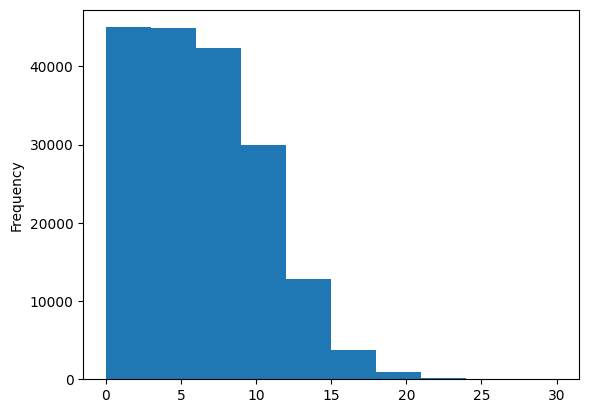

In [ ]:
#check the distribution of line numbers column
train_df.line_number.plot.hist()

In [ ]:
#use tensorflow to create one hot encoded tensors of our line number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we have encoded our line nuumber feature , lets do the same for our total line feature....

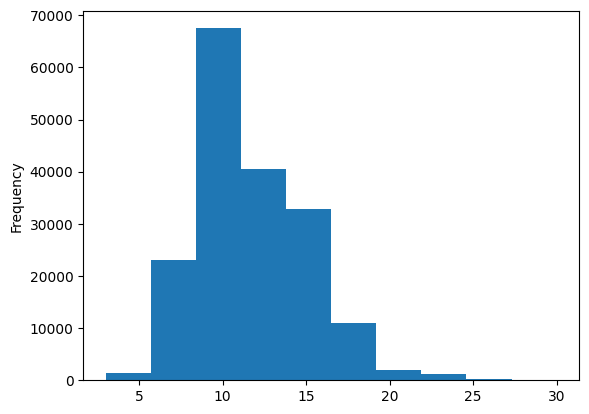

In [ ]:
#how many different number of lines there are?
#now checking the distribution
train_df.total_lines.plot.hist();

In [ ]:
#check the coverage of a total_lines value of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [ ]:
#use tensorflow to create one hot encoded tensors of our total lines feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### building a tribrid embedding model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_inputs")
token_embeddings = layers.Lambda(lambda x: tf_hub_embedding_layer(tf.squeeze(tf.cast(x, tf.string))))(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs, name="token_model")

# 2. Char inputs
char_inputs = layers.Input(shape=(), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
masking_layer = layers.Masking(mask_value=0)(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences=False))(masking_layer)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x, name="line_number_model")

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y, name="total_line_model")

# 5. Combine token and char embedding
combined_embeddings = layers.concatenate([token_model.output, char_model.output], name="char_token_hybrid_embedding")
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embedding = layers.concatenate([z, line_number_model.output, total_line_model.output], name="char_token_positional_embedding")

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embedding)

# 8. Put together with all kinds of inputs
model_5 = tf.keras.Model(
    inputs={
        "token_inputs": token_inputs,
        "char_inputs": char_inputs,
        "line_number_inputs": line_number_inputs,
        "total_lines_inputs": total_lines_inputs
    },
    outputs=output_layer,
    name="model_5_tribrid_embedding"
)

In [ ]:
model_5.summary()

Model: "model_5_tribrid_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_5 (NotEqual)    │ (None, 290, 25)        │              0 │ char_embed[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_1 (Masking)       │ (None, 290, 25)        │              0 │ char_embed[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_1 (Any)               │ (None, 290)            │              0 │ not_equal_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         65,664 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 48)             │          9,600 │ masking_1[0][0],       │
│ (Bidirectional)           │                        │                │ any_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_hybrid_embedd… │ (None, 176)            │              0 │ dense_7[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         45,312 │ char_token_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_inputs        │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_inputs        │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 32)             │            512 │ line_number_inputs[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 32)             │            672 │ total_lines_inputs[0]… │
├──────────────────────

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

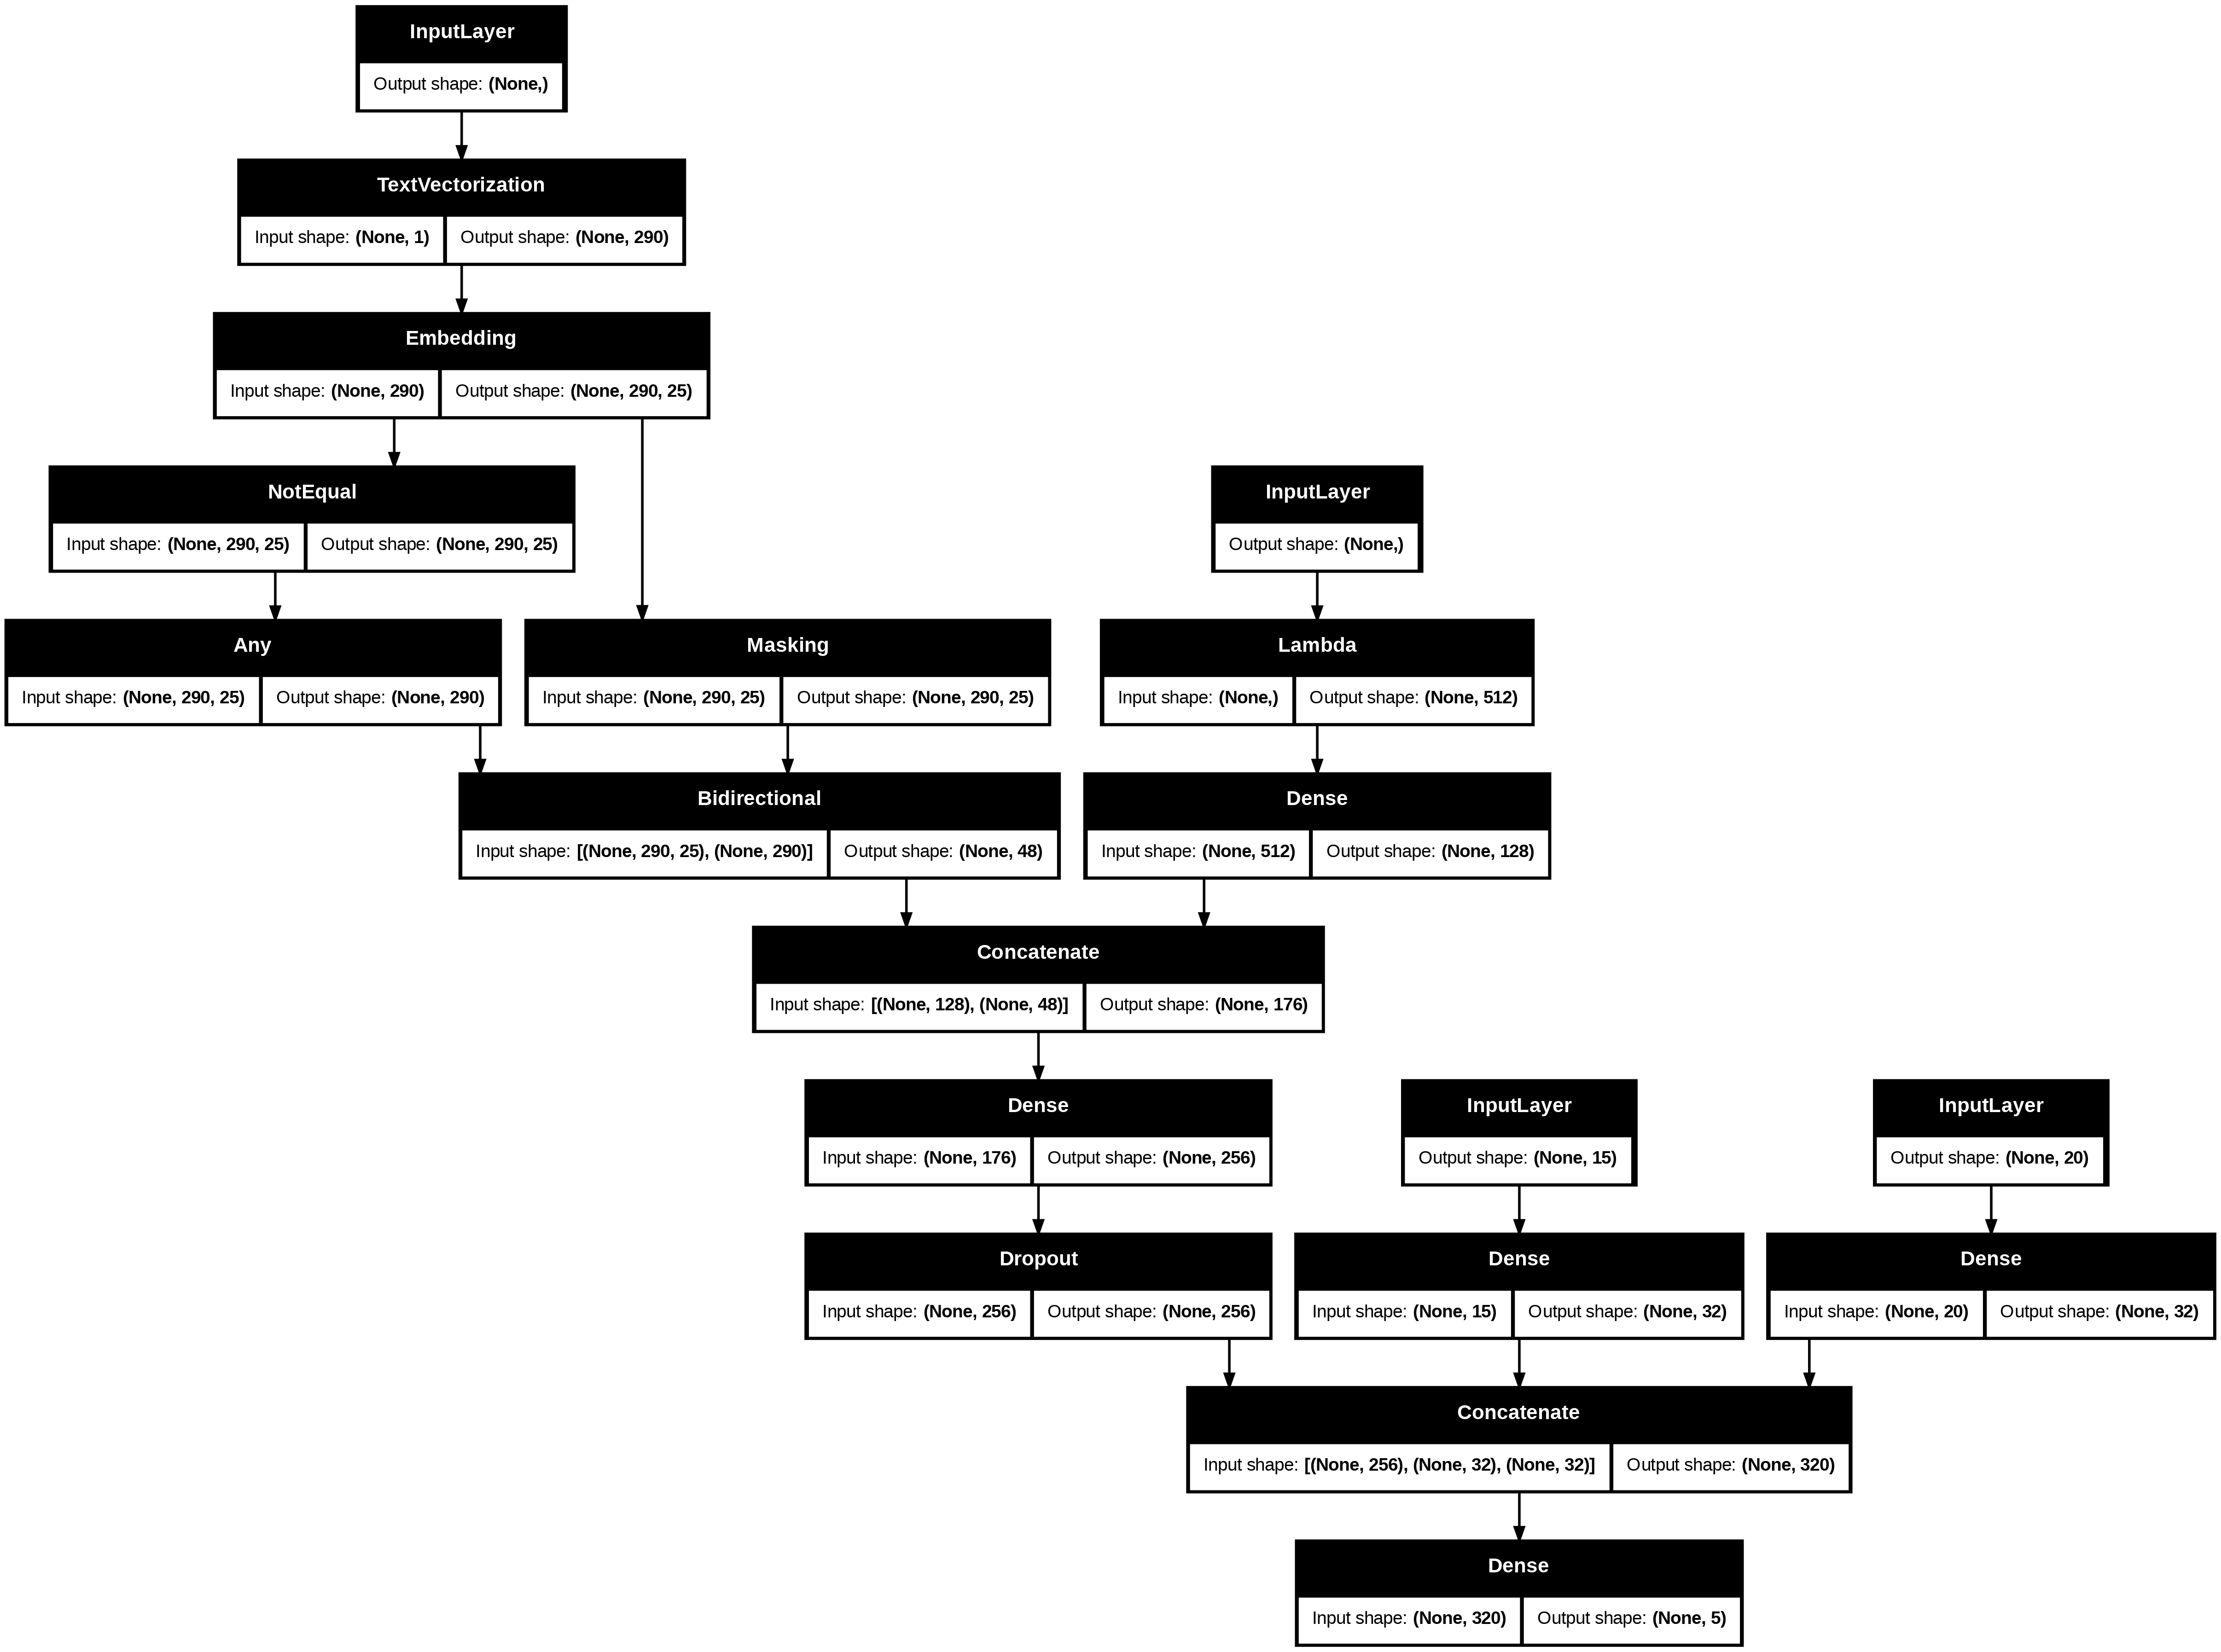

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

what label smoothing does is it assigns some of the value from the highest pred probs to other classes, in turn hopefully improving generalistaion

In [ ]:
#comnine  token, char and position embeddings
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                 optimizer=tf.keras.optimizers.Adam(), # Change 'optimizers' to 'optimizer'
                metrics = ["accuracy"])

### Create tribrid embedding dataset

In [ ]:
# Create training and validation dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices({
    "line_number_inputs": train_line_numbers_one_hot,
    "total_lines_inputs": train_total_lines_one_hot,
    "token_inputs": train_sentances,
    "char_inputs": train_chars
})

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices({
    "line_number_inputs": val_line_numbers_one_hot,
    "total_lines_inputs": val_total_lines_one_hot,
    "token_inputs": val_sentances,
    "char_inputs": val_chars
})

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

###fitting , evaluating our model 5

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(
    train_char_token_pos_dataset,
    steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
    epochs=3,
    validation_data=val_char_token_pos_dataset,
    validation_steps=int(0.1 * len(val_char_token_pos_dataset))
)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.6244 - loss: 1.2231 - val_accuracy: 0.8045 - val_loss: 0.9869
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8064 - loss: 0.9767 - val_accuracy: 0.8281 - val_loss: 0.9444
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.8193 - loss: 0.9574 - val_accuracy: 0.8288 - val_loss: 0.9392


In [ ]:
#make predictions with char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step


array([[0.49509135, 0.11211727, 0.01337953, 0.3615394 , 0.01787249],
       [0.5106151 , 0.11535108, 0.04732865, 0.31685   , 0.00985519],
       [0.2935642 , 0.11203051, 0.14811818, 0.3698109 , 0.07647622],
       ...,
       [0.03214861, 0.08928364, 0.0358839 , 0.02574613, 0.8169377 ],
       [0.03400477, 0.26751712, 0.07184663, 0.02784429, 0.59878725],
       [0.21706967, 0.55500203, 0.11567062, 0.04586776, 0.06638991]],
      dtype=float32)

In [ ]:
#convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
#calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results


{'accuracy': 83.13253012048193,
 'precision': 0.8305140672265001,
 'recall': 0.8313253012048193,
 'f1': 0.8304211324154106}

## compare model results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embeddings": model_3_results,
                                  "model_4_hybrid_char_token_embeddings": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.703826,0.784269,0.787038,0.784936
model_2_pretrained_token_embedding,71.322653,0.713373,0.713227,0.710136
model_3_custom_char_embeddings,65.857937,0.656242,0.658579,0.649120
model_4_hybrid_char_token_embeddings,71.981332,0.721703,0.719813,0.716834
model_5_pos_char_token_embedding,83.132530,0.830514,0.831325,0.830421


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

<Axes: >

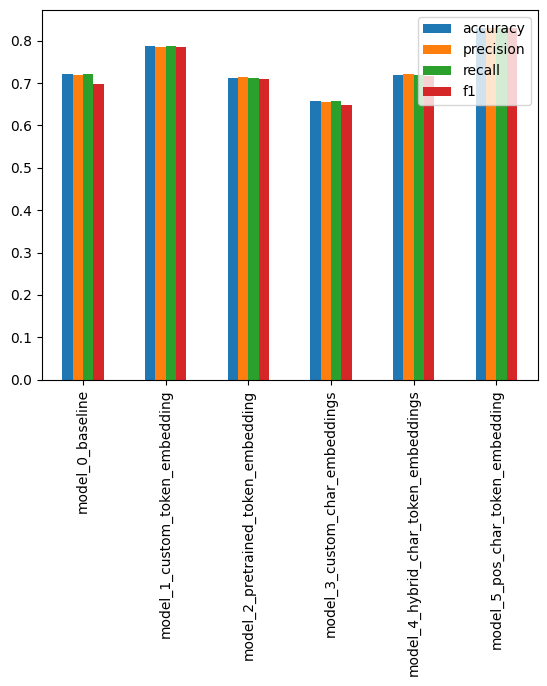

In [ ]:
all_model_results.plot(kind="bar")

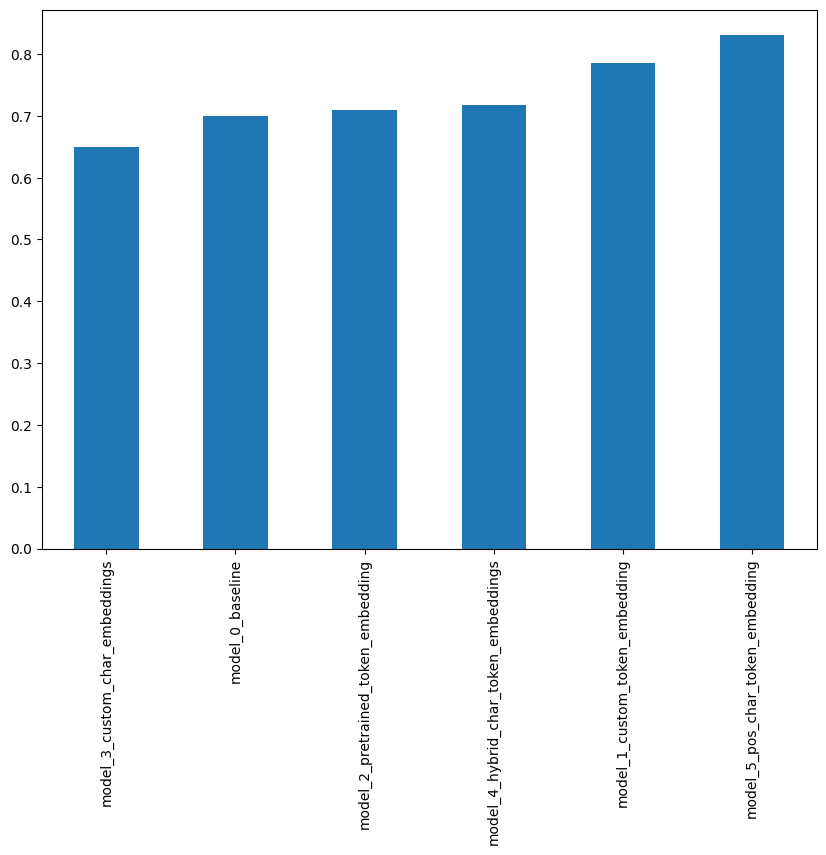

In [ ]:
#sort the model results by F1 scores
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7));
#

### save and load model

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model.keras") #

In [ ]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-08-11 16:39:30--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M   102MB/s    in 8.5s    

2024-08-11 16:39:38 (108 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/ski

In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, TFSMLayer

In [ ]:
model_path = "skimlit_gs_model/skimlit_tribrid_model/"

In [ ]:
# Load downloaded model from Google Storage as a TFSMLayer
loaded_model = TFSMLayer(model_path, call_endpoint='serving_default')

In [ ]:
#make predictions with model on validation set
loaded_pred_probs = model_5.predict(val_char_token_pos_dataset)
loaded_pred = tf.argmax(loaded_pred_probs, axis=1)
loaded_pred[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results=calculate_results(y_true=val_labels_encoded,
                                    y_pred=loaded_pred)
loaded_model_results

{'accuracy': 83.13253012048193,
 'precision': 0.8305140672265001,
 'recall': 0.8313253012048193,
 'f1': 0.8304211324154106}

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-08-11 16:54:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-08-11 16:54:05 (80.1 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts



,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[1]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.',
 'No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
 'Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.',
 "We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.",
 "Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.",
 "Vitamin D: no relevant RCT's were identified, however seven observational studies o

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.',
  'line_number': 0,
  'total_lines': 9},
 {'text': 'No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
  'line_number': 1,
  'total_lines': 9},
 {'text': 'Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.',
  'line_number': 2,
  'total_lines': 9},
 {'text': "We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.",
  'line_number': 3,
  'total_lines': 9},
 {'

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot


<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
     

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars


['P o s t p a r t u m   d e p r e s s i o n   ( P P D )   i s   t h e   m o s t   p r e v a l e n t   m o o d   d i s o r d e r   a s s o c i a t e d   w i t h   c h i l d b i r t h .',
 'N o   s i n g l e   c a u s e   o f   P P D   h a s   b e e n   i d e n t i f i e d ,   h o w e v e r   t h e   i n c r e a s e d   r i s k   o f   n u t r i t i o n a l   d e f i c i e n c i e s   i n c u r r e d   t h r o u g h   t h e   h i g h   n u t r i t i o n a l   r e q u i r e m e n t s   o f   p r e g n a n c y   m a y   p l a y   a   r o l e   i n   t h e   p a t h o l o g y   o f   d e p r e s s i v e   s y m p t o m s .',
 'T h r e e   n u t r i t i o n a l   i n t e r v e n t i o n s   h a v e   d r a w n   p a r t i c u l a r   i n t e r e s t   a s   p o s s i b l e   n o n - i n v a s i v e   a n d   c o s t - e f f e c t i v e   p r e v e n t i o n   a n d / o r   t r e a t m e n t   s t r a t e g i e s   f o r   P P D ;   o m e g a - 3   ( n - 3 )   l o n g   c h a i n   p o l y u 

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)

# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

In [ ]:
# Make predictions on sample abstract features
test_abstract_pred_probs = model_5.predict({
    "line_number_inputs": test_abstract_line_numbers_one_hot,
    "total_lines_inputs": test_abstract_total_lines_one_hot,
    "token_inputs": tf.constant(abstract_lines),
    "char_inputs": tf.constant(abstract_chars)
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 0, 2, 4, 4, 2, 4, 1, 1])>

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 0, 2, 4, 4, 2, 4, 1, 1])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes


['OBJECTIVE',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [ ]:

# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.
BACKGROUND: No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.
BACKGROUND: Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.
METHODS: We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.
RESULTS: Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.
RESULTS: Vitamin D: no relevant RCT's were identifie